<h1 style="text-align: center;"> Classificação de araras azuis utilizando o modelo resnet, regnet e levit.</h1>

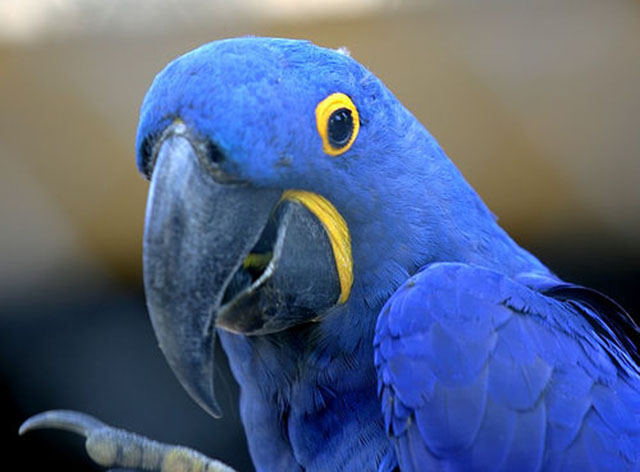


>"A arara-azul, também chamada arara-azul-grande, é uma espécie de ave, encontrada no Brasil, que se caracteriza por ser a maior entre os psitacídeos (família Psittacidae), chegando a atingir mais de um metro de comprimento, medindo-se da ponta do bico à ponta da cauda. Essa espécie habita diferentes formações vegetais, sendo encontrada em formações savânicas e até em ambientes de floresta no Brasil, Paraguai e Bolívia. As maiores populações dessa espécie de arara são encontradas no Pantanal."

## Qual seria o melhor modelo em classificação de araras ?

Diante da vasta fauna e muitas variedades de espécies qual seria a melhor rede neural para se classificar araras azuis de diversos pássaros encontrados na natureza ?

Bom, para responder essa questão utilizaremos nesse artigo algumas modelos de redes neurais diferentes, entre eles a classe de modelos resnet, regnet e levit. Dentre essas classes selecionaremos um modelo aleatório de cada grupo e compararemos as diferenças entre as classificações de cada um.

### Instalação de dependências

Vamos começar instalando as dependências necessárias utilizando o gerenciador de pacotes pip, note que comandos iniciados com ! siginifica códigos executados no terminal.

In [1]:
!pip install -Uqq fastbook fastai duckduckgo_search timm
import timm
import fastbook
fastbook.setup_book()
import timm
import random
from time import sleep

In [2]:
from fastbook import *
from fastai.vision.widgets import *

Para fazer o download necessário das imagens utilizaremos por padrão o DDG(DuckDuckGo Search)

In [3]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

Observe a quantidade de modelos disponíveis, sem dúvida um grande número e que pode nos causar uma certa dúvida sobre qual modelo usar ao classificar determinadas imagens.

In [4]:
len(timm.list_models(''))

964

#### Definição dos diretórios e dos modelos a serem classificados

Como dito anteriormente, classificaremos araras azuis de um grande espaço amostral de pássaros, para tal nós precisaremos baixar esses dados e colocá-los em pastas para serem posteriormente utilizados no treinamento e classificação.

In [5]:
searches = 'arara azul', 'bird'
path = Path('Arara_ou_outro')

### Download dos dados de treinamento

Baixaremos os dados utilizando um tamanho máximo de 400px, até por que os dados que utilizaremos serão treinados com tamanho de 224 px.

In [6]:
if not path.exists():
    path.mkdir()
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Algumas imagens podem não ser baixadas corretamente, portanto vamos removê-las para que o nosso modelo não seja prejudicado.

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

### Treinando nosso modelo

Para nosso *training set* utilizaremos um `Datablock` com validação de 20% (`RandomSplitter(valid_pct=0.2, seed=42)`), utilizaremos o diretório padrão (`get_y=parent_label`) com nome de `Arara_ou_outro` para treinar nosso modelo, note que utilizamos `RandomResizedCrop(224, min_scale=0.5)` para randomizar e manipular as imagens de treinamento no modelo, e utilizaremos também a função `aug_transforms()` que ela vira de cabeça pra baixo, faz a rotação, zoom, distorção, transformações de luz das imagens para treinamento do modelo.

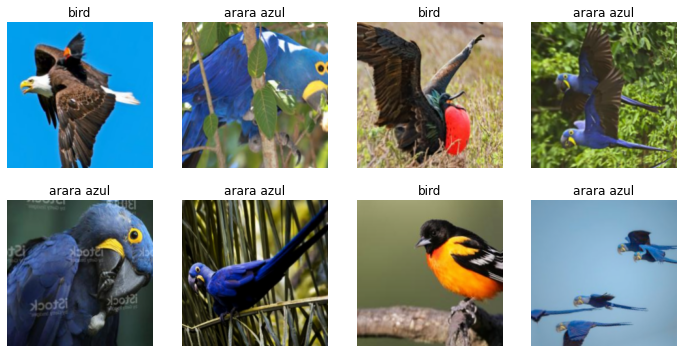

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()).dataloaders(path, bs=32)
dls.show_batch(max_n=8)

Observe a quantidade de modelos resnet(63), regnet(38), levit(6) existentes. 

É possível notar que existem mais de 960 modelos, para treinamentos dos mais variados, porém separei esses pois utilizam o mesmo tamanho de imagem (*224px*) e segundo o artigo https://www.kaggle.com/code/jhoward/which-image-models-are-best/ esses modelos apresentam uma boa eficiência.

#### Modelos resnet

In [9]:
len(timm.list_models('resnet*'))

63

#### Modelos regnet

In [10]:
len(timm.list_models('regnet*'))

38

#### Modelos levit

In [23]:
len(timm.list_models('levit*'))

6

### Seleção de um modelo aleatório de cada classe.

In [12]:
random.choice(timm.list_models('resnet*'))

'resnetv2_50d_evos'

In [13]:
random.choice(timm.list_models('regnet*'))

'regnety_006'

In [22]:
random.choice(timm.list_models('levit*'))

'levit_384'

## Treinamento dos modelos

Por se tratar de muitos modelos diferentes e não dispor de muitos recursos computacionais utilizarei apenas 3 épocas no `fine_tune()`. 

Utillizaremos da mesma metodologia, primeiro faremos o treinamento utilizando o modelo randomicamente, após isso utilizaremos a matriz de confusão para analisar onde estão os principais erros e depois mostraremos os piores casos com a função `plot_top_losses()`.

Como utilizamos apenas o modelo `resnet18` até o momento nos outros artigos, utilizaremos ele aqui para base de comparação.

### `resnet18`

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Mateus/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.797551,0.106123,0.052632,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.174151,0.046238,0.026316,00:19
1,0.226626,0.045927,0.026316,00:19
2,0.192524,0.049564,0.039474,00:19


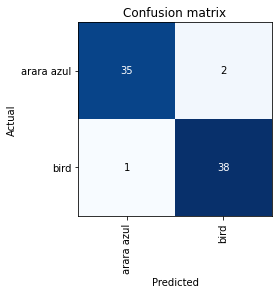

In [15]:
learn = vision_learner(dls, 'resnet18', metrics=error_rate)
learn.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

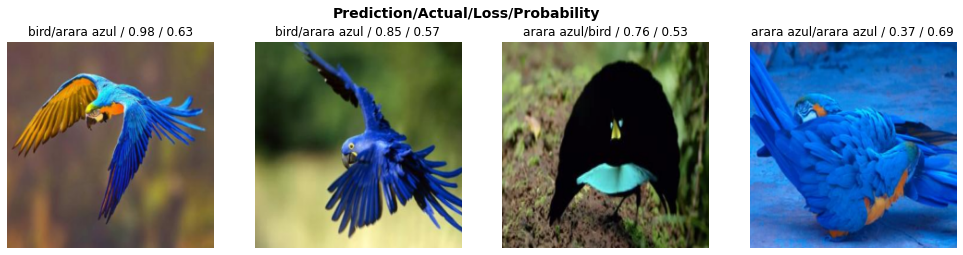

In [16]:
interp.plot_top_losses(4, nrows=1, figsize=(17,4))

### `resnetv2_50d_evos`

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tpu-weights/resnetv2_50d_evos_ah-7c4dd548.pth" to C:\Users\Mateus/.cache\torch\hub\checkpoints\resnetv2_50d_evos_ah-7c4dd548.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.567618,0.331800,0.026316,01:21


epoch,train_loss,valid_loss,error_rate,time
0,0.123621,0.216905,0.013158,02:36
1,0.093520,0.136985,0.000000,02:36
2,0.070557,0.061955,0.013158,02:41


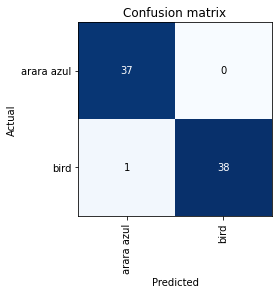

In [17]:
learn1 = vision_learner(dls, 'resnetv2_50d_evos', metrics=error_rate)
learn1.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

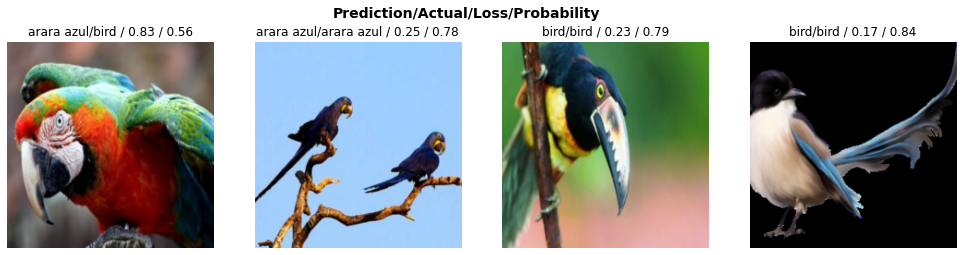

In [18]:
interp.plot_top_losses(4, nrows=1, figsize=(17,4))

### `regnety_006`

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_006-c67e57ec.pth" to C:\Users\Mateus/.cache\torch\hub\checkpoints\regnety_006-c67e57ec.pth
C:\Users\Mateus\AppData\Roaming\Python\Python310\site-packages\torch\amp\autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\Mateus\AppData\Roaming\Python\Python310\site-packages\torch\cuda\amp\grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time
0,0.901640,0.380483,0.118421,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.294860,0.105669,0.026316,00:21
1,0.224999,0.097210,0.026316,00:20
2,0.183929,0.099129,0.026316,00:21


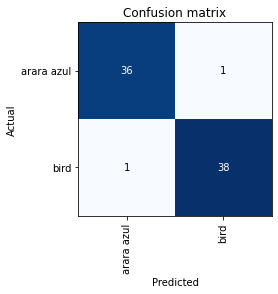

In [19]:
learn2 = vision_learner(dls, 'regnety_006', metrics=error_rate).to_fp16()
learn2.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix()

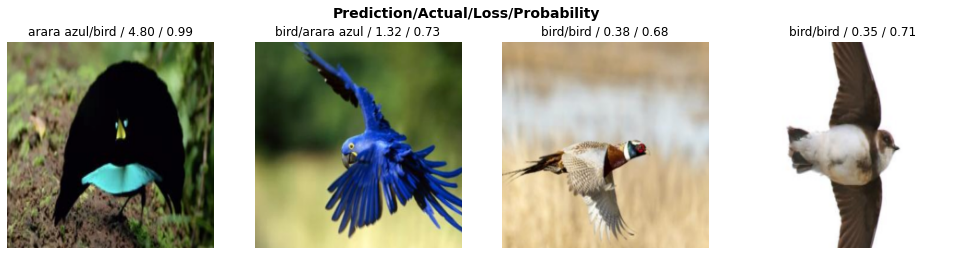

In [20]:
interp.plot_top_losses(4, nrows=1, figsize=(17,4))

### `levit_384`

C:\Users\Mateus\AppData\Roaming\Python\Python310\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://dl.fbaipublicfiles.com/LeViT/LeViT-384-9bdaf2e2.pth" to C:\Users\Mateus/.cache\torch\hub\checkpoints\LeViT-384-9bdaf2e2.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.894668,0.078950,0.026316,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.370879,0.062227,0.039474,00:54
1,0.279135,0.105021,0.039474,00:50
2,0.223558,0.099241,0.026316,00:50


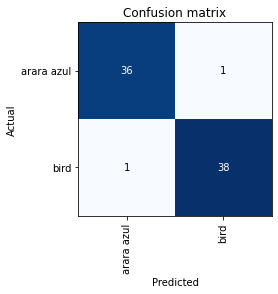

In [24]:
learn3 = vision_learner(dls, 'levit_384', metrics=error_rate).to_fp16()
learn3.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn3)
interp.plot_confusion_matrix()

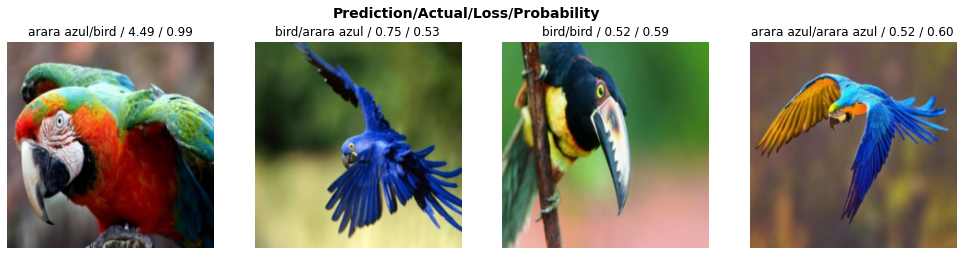

In [25]:
interp.plot_top_losses(4, nrows=1, figsize=(17,4))

## Análise dos dados

Podemos notar algumas diferenças entre os modelos treinados, note que utilizamos o mesmo `dataset` em todos os casos, porém os tempos de treino variaram bastante, tendo em média 19 segundos para o modelo `resnet18`, 2 minutos e 40 segundos para o modelo `resnetv2_50d_evos`, 20 segundos para o modelo `regnety_006` e 52 segundos para o modelo `levit_384`.

Os modelos `resnet18`, `resnetv2_50d_evos`, `regnety_006`, `levit_384` apresentaram respectivamente 3, 1, 2, 2 erros na predição através da matriz de confusão.

O menor erro foi obtido através da rede `resnetv2_50d_evos`, porém com o maior tempo de treinamento.

Ao usar a `plot_top_losses()`, podemos observar que cada rede por mais que tenha predito errado uma categoria, elas sempre apresentaram diferentes *top losses*. 

## É isso, muito obrigado !